In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import pickle
from tqdm.auto import trange, tqdm

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 모델 트레이닝

In [53]:
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_train_X.pkl', 'rb') as f:
    dnn_train_X = pickle.load(f)
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_train_y.pkl', 'rb') as f:
    dnn_train_y = pickle.load(f)
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_val_X.pkl', 'rb') as f:
    dnn_val_X = pickle.load(f)
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_val_y.pkl', 'rb') as f:
    dnn_val_y = pickle.load(f)

In [ ]:
# # 이 코드는 단번에 한시간 후 예측
# dnn_train_X = dnn_train_X[:-6]
# dnn_train_y = dnn_train_y[6:].reset_index(drop=True)
# dnn_val_X = dnn_val_X[:-6]
# dnn_val_y = dnn_val_y[6:].reset_index(drop=True)

In [54]:
# 날씨 열 제거
dnn_train_X.drop(dnn_train_X.columns[16:23], axis=1, inplace=True)
dnn_val_X.drop(dnn_val_X.columns[16:23], axis=1, inplace=True)
dnn_train_X.columns

Index(['Direction_0', 'Direction_1', 'Direction_2', 'Direction_3',
       'Direction_4', 'Direction_5', 'Direction_6', 'Direction_7',
       'Direction_8', 'Direction_9', 'Direction_10', 'Direction_11',
       'Direction_12', 'Direction_13', 'Direction_14', 'Direction_15',
       'holi_day', 'sign_1', 'sign_2', 'sign_3', 'sign_4', 'sign_5', 'sign_6',
       'direction'],
      dtype='object')

In [58]:
dnn_train_shuffle = pd.concat([dnn_train_X,dnn_train_y], axis=1).sample(frac=1, random_state=42)

dnn_train_y = dnn_train_shuffle['spead']
dnn_train_X = dnn_train_shuffle.drop('spead', axis=1)

In [61]:
def create_model(num_hidden_layers, num_dense_node, leaky_relu = 0.02):
    """
    주어진 히든 레이어 수에 따라 DNN 모델을 생성하는 함수

    :param input_dim: 입력 레이어의 노드 수
    :param num_hidden_layers: 히든 레이어의 수
    :num_dense_node: 레이어 하나에 노드 수
    :leaky_relu: LeakyReLU의 alpha 값
    :return: 생성된 모델
    """
    model = Sequential()
    model.add(Dense(num_dense_node, input_shape=(24,))) # 날씨 제외하여 24, 날씨 포함하면 31
    model.add(LeakyReLU(alpha=leaky_relu))

    for _ in range(num_hidden_layers):
        model.add(Dense(num_dense_node))
        model.add(LeakyReLU(alpha=leaky_relu))

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error')

    return model

In [62]:
# 히든 레이어 수와, 각 레이어의 노드 수
model = create_model(num_hidden_layers = 15, num_dense_node = 64)
model.summary()  # 모델 구조 출력

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 64)                1600      
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 64)               

In [63]:
early_stopping = EarlyStopping(patience=200)
model_checkpoint = ModelCheckpoint('dnn_best_model(weatherx).h5', save_best_only=True, monitor='val_loss')

hist = model.fit(dnn_train_X, dnn_train_y, epochs=300, batch_size=32,
                 validation_data=(dnn_val_X, dnn_val_y),
                 callbacks=[early_stopping, model_checkpoint])

Epoch 1/300
756/756 [==============================] - 9s 7ms/step - loss: 61.4779 - val_loss: 42.9521
Epoch 2/300
 20/756 [..............................] - ETA: 3s - loss: 42.5435

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


756/756 [==============================] - 4s 6ms/step - loss: 44.2025 - val_loss: 39.5458
Epoch 3/300
756/756 [==============================] - 4s 6ms/step - loss: 42.9939 - val_loss: 36.6783
Epoch 4/300
756/756 [==============================] - 5s 7ms/step - loss: 42.7076 - val_loss: 40.4215
Epoch 5/300
756/756 [==============================] - 4s 6ms/step - loss: 41.5316 - val_loss: 38.0726
Epoch 6/300
756/756 [==============================] - 4s 6ms/step - loss: 41.5565 - val_loss: 35.8490
Epoch 7/300
756/756 [==============================] - 5s 7ms/step - loss: 41.7210 - val_loss: 35.6474
Epoch 8/300
756/756 [==============================] - 4s 6ms/step - loss: 40.8398 - val_loss: 41.4952
Epoch 9/300
756/756 [==============================] - 4s 6ms/step - loss: 40.6855 - val_loss: 34.4550
Epoch 10/300
756/756 [==============================] - 5s 7ms/step - loss: 40.3252 - val_loss: 39.6320
Epoch 11/300
756/756 [==============================] - 4s 5ms/step - loss: 40.1446 

In [65]:
# 모델 사용하기
loaded_model = load_model('dnn_model(날씨 제거).h5')
loss_and_metrics = loaded_model.evaluate(dnn_val_X, dnn_val_y, batch_size = 32)

print('loss: ', loss_and_metrics)

72/72 [==============================] - 0s 3ms/step - loss: 8.0382
loss:  8.038248062133789


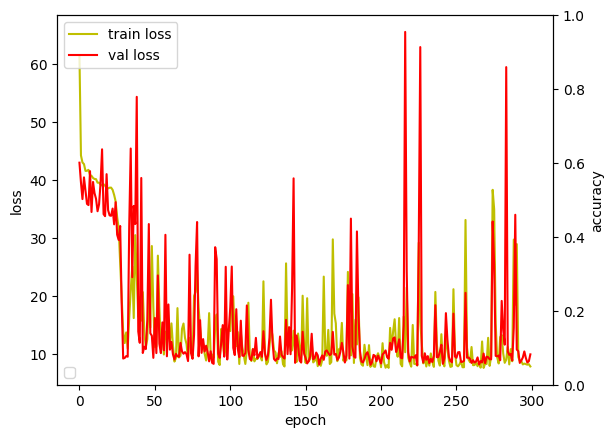

In [66]:
# 모델 학습과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

#plt.title('layer=13 node=64 loss = '+str(loss_and_metrics))
plt.show()

In [ ]:
# dnn_val_X_reset = dnn_val_X.reset_index(drop=True)
# dnn_val_y_reset = dnn_val_y.reset_index(drop=True)

72/72 [==============================] - 0s 2ms/step


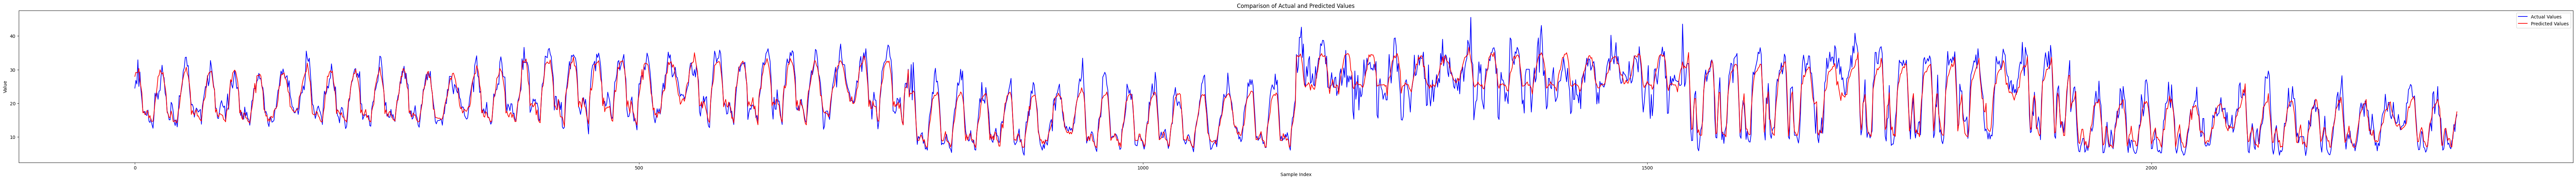

In [67]:
# 모델을 사용하여 예측 수행
predicted_val_y = loaded_model.predict(dnn_val_X)

# 실제 값과 예측값을 선 그래프로 표시
plt.figure(figsize=(100, 6))
plt.plot(dnn_val_y, label='Actual Values', color='blue')
plt.plot(predicted_val_y, label='Predicted Values', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()